In [1]:
import os
import imageio
import pickle
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import lpips
from pytorch_msssim import ms_ssim

In [2]:
def plot_image(tensor, plot_size=(10,10)):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  plt.rcParams["figure.figsize"] = plot_size
  plt.imshow(img)


def save_image(tensor, path):
  tensor = (tensor.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  img = Image.fromarray(tensor[0].cpu().numpy(), 'RGB')
  img.save(path)


def broadcast_w_sg(w_batch, cast_n=18):
    input_ws = []
    for w in w_batch:
        w_broadcast = torch.broadcast_to(w, (cast_n, 512))
        input_ws.append(w_broadcast)
    return torch.stack(input_ws)


def image2tensor_norm(image):
    transform = transforms.Compose([transforms.ToTensor(),
                                   transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5])])
    tensor = transform(image)
    return tensor

In [3]:

# https://pypi.org/project/pytorch-msssim/
class Rec_loss(nn.Module):
    def __init__(self):
        super().__init__()
        self.l1_criterion = torch.nn.L1Loss(reduction='mean')

    def forward(self, target, synth):
        target = torch.add(target, 1.0)
        target = torch.mul(target, 127.5)
        target = target / 255

        synth = torch.add(synth, 1.0)
        synth = torch.mul(synth, 127.5)
        synth = synth / 255

        loss = torch.mean(1 - ms_ssim(synth, target, data_range=1, size_average=True))
        return loss


# https://pypi.org/project/lpips/
class Lpips_loss(nn.Module):
    def __init__(self, device):
        super().__init__()
        self.lpips_loss = lpips.LPIPS(net='vgg')
        self.lpips_loss.to(device)
        self.lpips_loss.eval()

    def forward(self, target, synth):
        return torch.mean(self.lpips_loss(target, synth))
    

# https://github.com/NVlabs/stylegan2-ada-pytorch/blob/main/projector.py#L104
class Reg_loss(nn.Module):
    def __init__(self, noise_bufs):
        super().__init__()
        self.noise_bufs = noise_bufs

    def forward(self,):
        reg_loss = 0.0
        for v in self.noise_bufs.values():
            noise = v[None,None,:,:] # must be [1,1,H,W] for F.avg_pool2d()
            while True:
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=3)).mean()**2
                reg_loss += (noise*torch.roll(noise, shifts=1, dims=2)).mean()**2
                if noise.shape[2] <= 8:
                    break
                noise = F.avg_pool2d(noise, kernel_size=2)
        return reg_loss

In [4]:
device = "cuda:0"
model_path = "/shared/data/ffhq.pkl"
with open(model_path, 'rb') as f:
    G = pickle.load(f)['G_ema'].cuda()

In [ ]:

# загружаем изображение
inv_img_path = "/shared/data/jason.png"
target_pil = Image.open(inv_img_path).convert('RGB')
target_tensor = image2tensor_norm(target_pil).to(device).unsqueeze(0)

noise_bufs = { name: buf for (name, buf) in G.synthesis.named_buffers() if 'noise_const' in name }

# инициализируем функции потерь
lpips_loss = Lpips_loss(device)
rec_loss = Rec_loss()
reg_loss = Reg_loss(noise_bufs)

#  loss weights 
regularize_noise_weight = 5e5
rec_weight = 0.5
lpips_weoght = 1

# Параметры для оптимизации
num_steps = 150
seed = 42
initial_learning_rate = 0.05
w_avg_samples = 10000

# Получаем средний вектор латентного пространства
z_samples = torch.from_numpy(np.random.RandomState(seed).randn(w_avg_samples, G.z_dim)).to(device)
w_samples = G.mapping(z_samples, None)
w_samples = w_samples[:, :1, :].cpu().numpy().astype(np.float32)
w_avg = np.mean(w_samples, axis=0, keepdims=True)   # [1, 1, C]
w_std = (np.sum((w_samples - w_avg) ** 2) / w_avg_samples) ** 0.5

# w or w_plus 
w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=False) # pylint: disable=not-callable
w_opt = broadcast_w_sg(w_opt).requires_grad_(True)
# w_opt = torch.tensor(w_avg, dtype=torch.float32, device=device, requires_grad=True) # pylint: disable=not-callable

optimizer = torch.optim.Adam([w_opt], lr=initial_learning_rate)

generated_tensors = []
for step in tqdm(range(num_steps)):
  synth_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const')

  lpips_value = lpips_loss(synth_tensor, target_tensor)
  rec_value = rec_loss(synth_tensor, target_tensor)
  reg_value = reg_loss()

  loss = lpips_value*lpips_weoght + rec_value*rec_weight + reg_value*regularize_noise_weight

  optimizer.step()
  optimizer.zero_grad(set_to_none=True)
  loss.backward()
  generated_tensors.append(synth_tensor)
generated_tensor = G.synthesis(broadcast_w_sg(w_opt), noise_mode='const', force_fp32=True)

# save_image(generated_tensor, path="./projected_image.png")

print(loss.item())


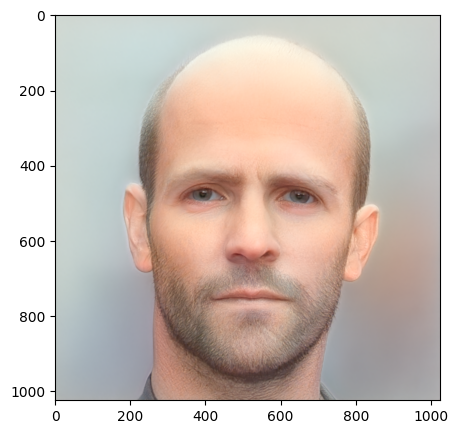

In [7]:
plot_image(generated_tensor, plot_size=(5,5))

In [ ]:
video = imageio.get_writer(f'/shared/out/proj_video.mp4', mode='I', fps=10, codec='libx264', bitrate='16M')
target_uint8 = np.array(target_pil, dtype=np.uint8)
print (f'Saving optimization progress video "/shared/out/proj_video.mp"')
for synth_image in generated_tensors:
    synth_image = (synth_image + 1) * (255/2)
    synth_image = synth_image.permute(0, 2, 3, 1).clamp(0, 255).to(torch.uint8)[0].cpu().numpy()
    video.append_data(np.concatenate([target_uint8, synth_image], axis=1))
video.close()